In [176]:
import collections
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from matplotlib.colors import ListedColormap
from scipy.stats import gaussian_kde
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer

np.random.seed(13)

Препроцессинг данных из предыдущей лабы.

In [177]:
data = pd.read_csv('diabetes.csv')
data.drop_duplicates(inplace=True)
sample = data[data['Outcome'] == 1]
while data[data['Outcome'] == 1].shape[0] + sample.shape[0] < data[data['Outcome'] == 0].shape[0]:
    data = pd.concat([data, sample])
data = pd.concat([data, sample.iloc[:data[data['Outcome'] == 0].shape[0] - data[data['Outcome'] == 1].shape[0]]])

In [178]:
def Metrics(pipe : Pipeline, data, labels):
    pred = pipe.predict(data)
    print('Accuracy:', accuracy_score(labels, pred))
    print('Precision:', precision_score(labels, pred))
    print('Recall:', recall_score(labels, pred))
    figure = plt.figure(figsize=(14, 6))
    matrix = confusion_matrix(labels, pred)
    ax = plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay(matrix).plot(ax=ax)
    ax = plt.subplot(1, 2, 2)
    RocCurveDisplay.from_predictions(labels, pred, ax=ax)
    plt.subplots_adjust(wspace=0.4)
    plt.show()

Разделение на тестовые и обучающии выборки.

In [179]:
x = data.drop(columns = 'Outcome').to_numpy()
y = data['Outcome'].to_numpy()
train_data, test_data, train_labels, test_labels = train_test_split(x, y, train_size=0.8, random_state = 42 )

# LogisticRegression

## Ручная

In [180]:
class LogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, lr = 0.1, batch = 5, epochs = 5, alpha = 0.01):
        self.lr = lr
        self.batch = batch
        self.epochs = epochs
        self.alpha = alpha
    
    def sigmoid(self, x):
        x = np.clip(x, -10, 10)
        return 1.0 / (1.0 + np.exp(-x))
    
    def fit(self, data, labels):
        self.w = np.random.normal(0, 1, (data.shape[1]+1,))
        data = np.concatenate((data, np.ones((data.shape[0],1))), axis=1)
        for _ in range(self.epochs):
            for i in range(self.batch, len(data), self.batch):
                data_batch = data[i-self.batch:i]
                labels_batch = labels[i-self.batch:i]
                
                pred = self.sigmoid(np.dot(self.w, data_batch.T))
                grad = 2 * self.alpha * self.w + np.dot(pred - labels_batch, data_batch)
                
                self.w -= self.lr * grad
        return self
    
    def predict(self, data):
        return (self.sigmoid(np.concatenate((data, np.ones((data.shape[0],1))), axis=1).dot(self.w)) > 0.5).astype('int64')

In [181]:
pipe = Pipeline([('normalizer', Normalizer()), ('log', LogisticRegression())])

log_reg = GridSearchCV(pipe, {'log__lr': [0.1, 0.01, 0.001], 'log__epochs': [5, 10, 20], 
                     'log__batch': [5, 100, 2000], 'log__alpha': [0.01, 0.001, 0.0001]})
log_reg.fit(train_data, train_labels)
print(log_reg.best_params_, log_reg.best_score_, sep='\n')

{'log__alpha': 0.0001, 'log__batch': 5, 'log__epochs': 10, 'log__lr': 0.1}
0.6537499999999999


Accuracy: 0.555
Precision: 0.575
Recall: 0.45544554455445546


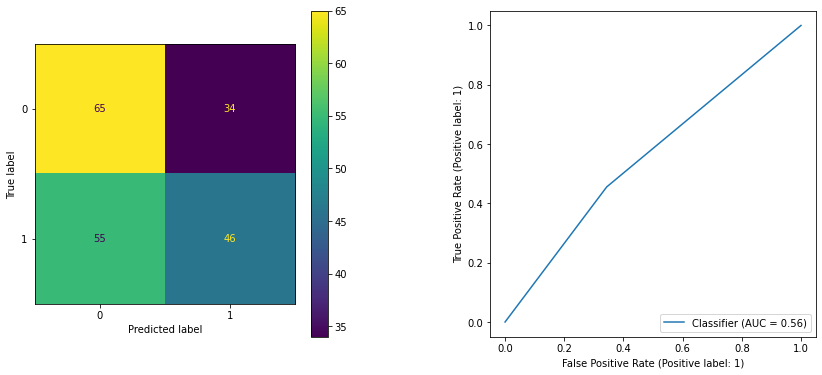

In [182]:
log = log_reg.best_estimator_
Metrics(log, test_data, test_labels)

## Коробочная

In [183]:
pipe = Pipeline([('normalizer', Normalizer()), ('log', SGDClassifier(loss='log', learning_rate='constant'))])

sk_log_reg = GridSearchCV(pipe, {'log__eta0': [0.1, 0.01, 0.001], 'log__max_iter': [100, 1000, 10000], 'log__alpha': [0.01, 0.001, 0.0001]})
sk_log_reg.fit(train_data, train_labels)
print(sk_log_reg.best_params_, sk_log_reg.best_score_, sep='\n')


{'log__alpha': 0.001, 'log__eta0': 0.1, 'log__max_iter': 1000}
0.65375


Accuracy: 0.55
Precision: 0.5733333333333334
Recall: 0.42574257425742573


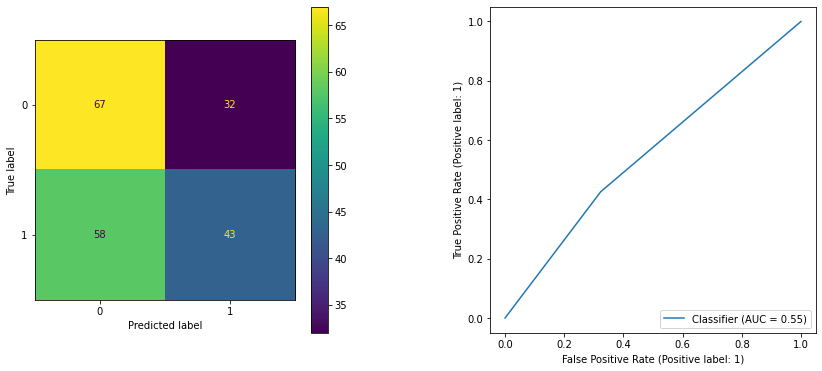

In [184]:
sk_log = sk_log_reg.best_estimator_
Metrics(sk_log, test_data, test_labels)

 Довольно низкие показатели связаны с тем, как расположены облака признаков. В отчёте к прошлой лабе указал это.

# SVM

## Ручная

In [185]:
class SVM(BaseEstimator, ClassifierMixin):
    def __init__(self, lr = 0.1, batch = 5, epochs = 5, alpha = 0.01):
        self.lr = lr
        self.batch = batch
        self.epochs = epochs
        self.alpha = alpha
    
    def fit(self, data, labels):
        self.w = np.random.normal(0, 1, (data.shape[1]+1,))
        data = np.concatenate((data, np.ones((data.shape[0],1))), axis=1)
        labels = labels * 2 - 1
        for _ in range(self.epochs):
            for i in range(self.batch, len(data), self.batch):
                data_batch = data[i-self.batch:i]
                labels_batch = labels[i-self.batch:i]
                
                grad = 2 * self.alpha * self.w
                for i, x in enumerate(data_batch):
                    if 1 - x.dot(self.w) * labels_batch[i] > 0:
                        grad -= x * labels_batch[i]
                
                self.w -= self.lr * grad
        return self

    def predict(self, data):
        return (np.sign(np.concatenate((data, np.ones((data.shape[0],1))), axis=1).dot(self.w)) + 1) / 2


In [186]:
pipe = Pipeline([('scaler', StandardScaler()), ('svm', SVM())])
SVM = GridSearchCV(pipe, {'svm__lr': [0.1, 0.01, 0.001], 'svm__epochs': [1, 10, 100], 
                     'svm__batch': [10, 100, 1000], 'svm__alpha': [0.01, 0.001, 0.0001]})
SVM.fit(train_data, train_labels)
print(SVM.best_params_, SVM.best_score_, sep='\n')

{'svm__alpha': 0.0001, 'svm__batch': 10, 'svm__epochs': 100, 'svm__lr': 0.001}
0.7575


Accuracy: 0.76
Precision: 0.7523809523809524
Recall: 0.7821782178217822


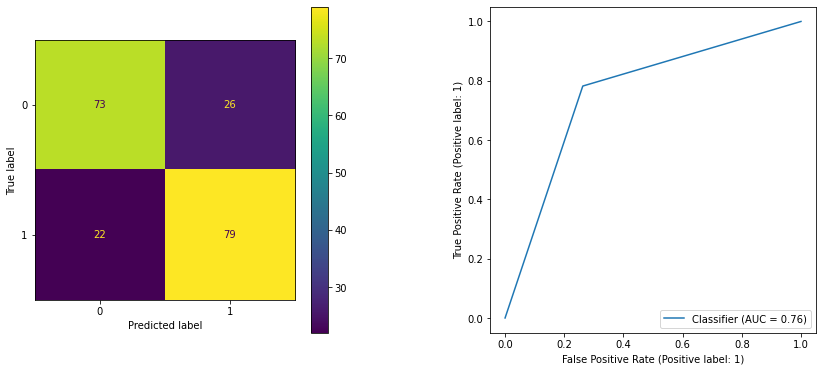

In [187]:
best_svm = SVM.best_estimator_
Metrics(best_svm, test_data, test_labels)

## Коробочная

In [188]:
pipe = Pipeline([('normalizer', Normalizer()), ('svm', SGDClassifier(loss='hinge', learning_rate='constant'))])

SVM_sk = GridSearchCV(pipe, {'svm__eta0': [0.1, 0.01, 0.001], 'svm__max_iter': [100, 1000, 5000], 
                     'svm__alpha': [0.01, 0.001, 0.0001]})
SVM_sk.fit(train_data, train_labels)
print(SVM_sk.best_params_, SVM_sk.best_score_, sep='\n')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


{'svm__alpha': 0.0001, 'svm__eta0': 0.1, 'svm__max_iter': 5000}
0.64375


Accuracy: 0.59
Precision: 0.6067415730337079
Recall: 0.5346534653465347


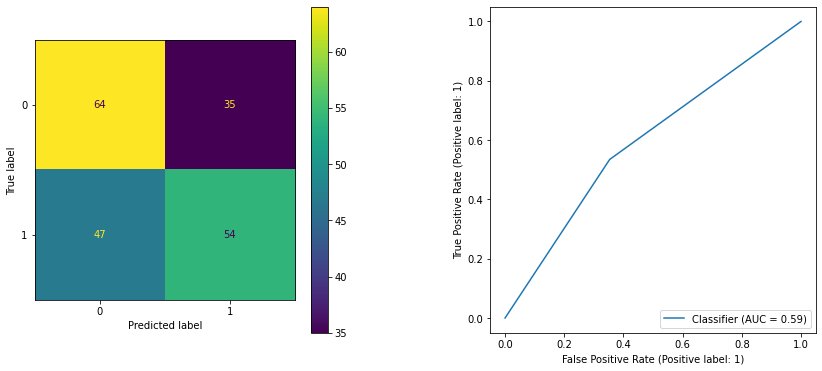

In [189]:
sk_svm = SVM_sk.best_estimator_
Metrics(sk_svm, test_data, test_labels)

# KNN

## Ручная реализация

In [190]:
class KNN(BaseEstimator, ClassifierMixin):
    def __init__(self, k = 5):
        self.k = k
        
    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        
    def euclidean_distance(self, row1, row2):
        distance = 0
        for i in range(len(row1)): 
            distance += (row1[i] - row2[i]) ** 2
        return math.sqrt(distance)
        
    def predict(self, maindata):
        res = np.ndarray((maindata.shape[0],))
        for j, data in enumerate(maindata):
            distances = []
            for i, row in enumerate(self.data):
                distances.append((self.euclidean_distance(data, row), self.labels[i]))
            distances.sort(key = lambda tup: tup[0])
            dictionary = collections.defaultdict(int)
            for i in range(self.k):
                dictionary[distances[i][1]] += 1
            res[j] = max(dictionary.items(), key = lambda tup: tup[1])[0]
        return res

In [191]:
pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNN())])
my_knn = GridSearchCV(pipe, {'knn__k': [1, 3, 10, 15, 25]})
my_knn.fit(train_data, train_labels)
print(my_knn.best_params_, my_knn.best_score_, sep='\n')

{'knn__k': 1}
0.79125


Accuracy: 0.865
Precision: 0.8135593220338984
Recall: 0.9504950495049505


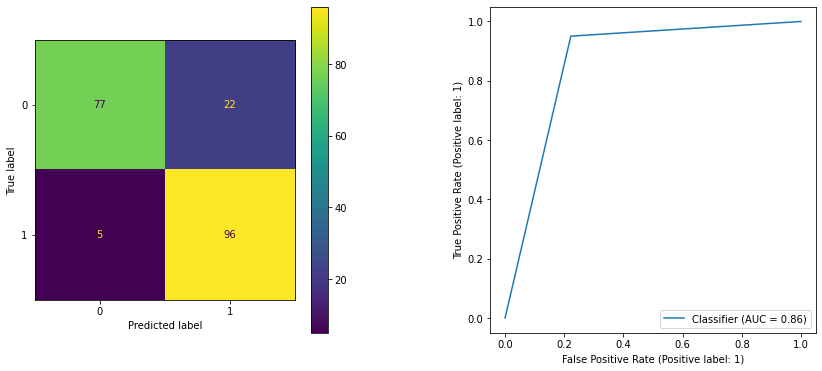

In [192]:
knn = my_knn.best_estimator_
Metrics(knn, test_data, test_labels)

## Коробочная реализация

In [193]:
pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
sc_my_knn = GridSearchCV(pipe, {'knn__n_neighbors': [1, 3, 10, 15, 25]})
sc_my_knn.fit(train_data, train_labels)
print(sc_my_knn.best_params_, sc_my_knn.best_score_, sep='\n')

{'knn__n_neighbors': 1}
0.79125


Accuracy: 0.865
Precision: 0.8135593220338984
Recall: 0.9504950495049505


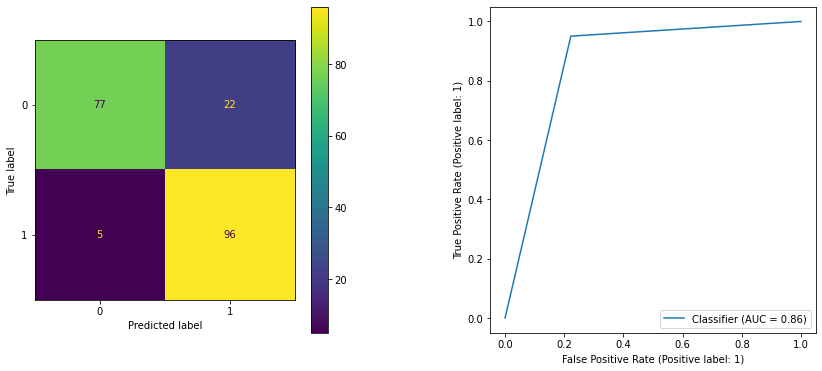

In [194]:
sk_knn = sc_my_knn.best_estimator_
Metrics(sk_knn, test_data, test_labels)

In [195]:
file = open('knn.pkl', 'wb')
pickle.dump(knn, file, pickle.HIGHEST_PROTOCOL)
file.close()

# Naive Bayes

## Ручная реализация.

In [196]:
class NaiveBayes(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass
    
    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        self.kde = []
        for c, count in zip(*np.unique(labels, return_counts=True)):
            self.kde.append([])
            for i in range(data.shape[1]):
                self.kde[-1].append(gaussian_kde(data[labels == c, i]))
        self.classes = np.unique(labels, return_counts=True)[1] / len(labels)
        return self
    
    def predict(self, data):
        res = np.ndarray((data.shape[0],))
        for i, obj in enumerate(data):
            prob = np.array(self.classes)
            for j in range(len(self.classes)):
                for k, kde in enumerate(self.kde[j]):
                    prob[j] *= kde(obj[k])[0]
            res[i] = prob.argmax()
        return res

Accuracy: 0.76
Precision: 0.7476635514018691
Recall: 0.7920792079207921


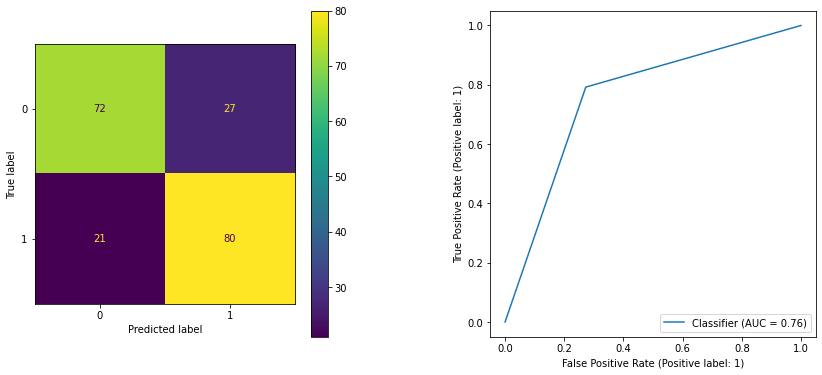

In [197]:
nb = Pipeline([('bayes', NaiveBayes())])
nb.fit(train_data, train_labels)
Metrics(nb, test_data, test_labels)

In [198]:
file = open('nb.pkl', 'wb')
pickle.dump(nb, file, pickle.HIGHEST_PROTOCOL)
file.close()

## Коробочная.

Accuracy: 0.745
Precision: 0.7659574468085106
Recall: 0.7128712871287128


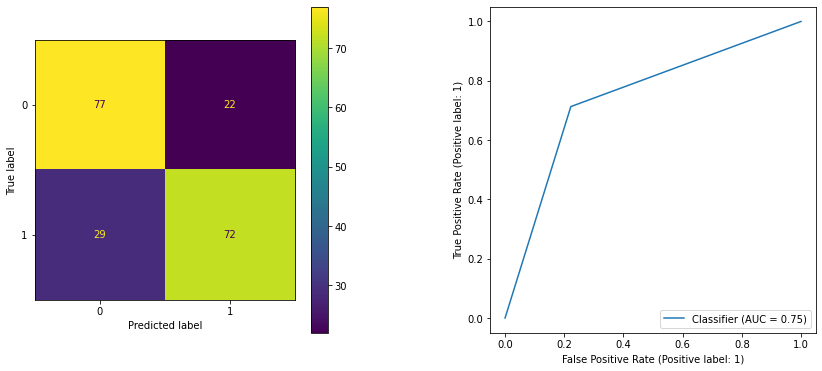

In [199]:
sk_gnb = GaussianNB()
sk_gnb.fit(train_data, train_labels)
Metrics(sk_gnb, test_data, test_labels)